In [4]:
import pandas as pd

graph2018_path = "graph2018.gz"
graph2019_path = "graph2019.gz"
graph2020_path = "graph2020.gz"

output_gz_path = "aggregated_graph.gz"
output_gml_path = "aggregated_graph.gml"

In [5]:
import networkx as nx

import collections
from collections import Counter

import matplotlib
from matplotlib import pyplot as plt

import math

from networkx.algorithms import community as comm
import itertools

from operator import itemgetter

import string

import numpy as np

from sklearn import cluster

import copy

# Ucitavanje mreza

In [6]:
G_2018 = nx.read_gexf(graph2018_path)
G_2019 = nx.read_gexf(graph2019_path)
G_2020 = nx.read_gexf(graph2020_path)

print(nx.info(G_2018))
print(nx.info(G_2019))
print(nx.info(G_2020))

Name: 
Type: Graph
Number of nodes: 291
Number of edges: 2271
Average degree:  15.6082
Name: 
Type: Graph
Number of nodes: 281
Number of edges: 2215
Average degree:  15.7651
Name: 
Type: Graph
Number of nodes: 244
Number of edges: 1216
Average degree:   9.9672


# Agregiranje mreza

In [7]:
G = nx.Graph()

def add_nodes(G_year):
    for node,data in G_year.nodes(data=True):
        if (node not in G.nodes()):
            G.add_node(node,player_name=data['player_name'], country_code=data['country_code'])
            
add_nodes(G_2018)   
add_nodes(G_2019)   
add_nodes(G_2020)  

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 390
Number of edges: 0
Average degree:   0.0000


## Racunanje ranka

In [8]:
def get_rank_attribute(id):
    rank_2018 = rank_2019 = rank_2020 = 0
    if id in G_2018.nodes:
        rank_2018 = G_2018.nodes[id]['rank'] if not np.isnan(G_2018.nodes[id]['rank']) else 0
    if id in G_2019.nodes:
        rank_2019 = G_2019.nodes[id]['rank'] if not np.isnan(G_2019.nodes[id]['rank']) else 0
    if id in G_2020.nodes:
        rank_2020 = G_2020.nodes[id]['rank'] if not np.isnan(G_2020.nodes[id]['rank']) else 0
        
    num_of_zeros = [rank_2018,rank_2019,rank_2020].count(0)
    if num_of_zeros==3:
        return float('NaN')
    if num_of_zeros>0:
        return (rank_2018+rank_2019+rank_2020)/(3-num_of_zeros)
    return rank_2018*0.33+rank_2019*0.39+rank_2020*0.28
    #return rank_2018*0.28+rank_2019*0.33+rank_2020*0.39

In [9]:
33+39+28

100

In [10]:
for node in G.nodes():
    G.nodes[node]['rank']=get_rank_attribute(node)

## Dodavanje grana

In [11]:
def add_edges(G_year):
    for source,target,w in G_year.edges(data='weight'):
        if (source, target) not in G.edges():
            G.add_edge(source, target,weight=int(w))
        else:
            G.edges[source,target]['weight'] += int(w)
            
add_edges(G_2018)   
add_edges(G_2019)   
add_edges(G_2020)  

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 390
Number of edges: 4878
Average degree:  25.0154


# Pomocne metode (uz modelovan graf)

In [12]:
def get_player_by_name(player_name):
    nodes = [node for node,name in G.nodes(data='player_name') if name==player_name]
    player = 0
    if len(nodes)>0:
        player = nodes[0]
    return player

def get_players_matches(id):
    mask = (cleaned_matches['winner_id']==id) | (cleaned_matches['loser_id']==id)
    return matches[mask]

In [13]:
def get_nodes_by_attribute(G,attribute, value):
    return [n for n,v in G.nodes(data=True) if v[attribute] == value]

In [14]:
def get_players_degrees(G,players):
    return [(node,name,G.degree(node)) for (node,name) in tourney_graph.nodes(data='player_name') if node in players]

In [15]:
def get_player_attribute(G,player,attribute):
    return [v[attribute] for n,v in G.nodes(data=True) if  n== player]

In [16]:
def get_player_info(id):
    return (id,G.nodes[id]['player_name'],G.nodes[id]['rank'],G.nodes[id]['country_code'])
    #return tuple([(node,attr['player_name'],attr['rank'],attr['country_code']) for (node,attr) in G.nodes(data=True) if node==id])

def get_players_info(players):
    infos = []
    for player in players:
        infos.append(get_player_info(player))
    return infos  

In [17]:
def get_players_opponents_info(id):
    opponents = nx.node_connected_component(G, id)
    return get_players_info(opponents)

In [18]:
def plot_deg_frequency(G, weighted=False, xscale = "log", yscale = "log"):

    if weighted:
        degrees = G.degree(weight="weight")
    else:
        degrees = G.degree()
    _, deg_list = zip(*degrees)    #unzip
    deg_counts = Counter(deg_list) #prebrojava, 1, 2, ..        
    print(deg_counts)
    degree, frequency = zip(*deg_counts.items())                                                      

    plt.figure(1)   

    # prep axes   
    if weighted:
        plt.xlabel('weighted degree')  
    else:
        plt.xlabel('degree')                                                                                                             
    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(degree))  

    plt.ylabel('frequency')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(frequency))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(degree, frequency, marker='.')                                                                                                    
    plt.show()

# Istrazivacka pitanja

# 1. Koliki je prosečan broj tenisera (saigrača) po svakom teniseru?

In [19]:
def get_average_degree(G):
    num_of_nodes = G.number_of_nodes()
    degree = sum(d for n, d in G.degree()) / float(num_of_nodes)
    return degree

def get_average_weighted_degree(G):
    num_of_nodes = G.number_of_nodes()
    degree = sum(d for n, d in G.degree(weight='weight')) / float(num_of_nodes)
    return degree  

In [20]:
print(f"Prosecan broj saigraca svakog tenisera: {get_average_degree(G)}")   

Prosecan broj saigraca svakog tenisera: 25.015384615384615


In [21]:
print(f"Prosecan broj meceva svakog tenisera: {get_average_weighted_degree(G)}")

Prosecan broj meceva svakog tenisera: 33.84615384615385


# 2. Koji teniseri su se susretali sa najvećim brojem drugih tenisera? 

In [22]:
degrees = [G.degree(node) for node in G.nodes()]
max_degree = max(degrees)

players_degrees = [(node,name,G.degree(node)) for (node,name) in G.nodes(data='player_name')]

high_degree_players = (sorted(players_degrees, key=lambda element: (element[2]),reverse=True))[:10]

print(f"Max stepen: {max_degree}")
print(f"Igraci koji su igrali sa najvise drugih igraca: {high_degree_players}")

Max stepen: 99
Igraci koji su igrali sa najvise drugih igraca: [('111575', 'Karen Khachanov', 99), ('126774', 'Stefanos Tsitsipas', 97), ('106421', 'Daniil Medvedev', 95), ('100644', 'Alexander Zverev', 93), ('104792', 'Gael Monfils', 93), ('104926', 'Fabio Fognini', 93), ('104468', 'Gilles Simon', 91), ('105138', 'Roberto Bautista Agut', 91), ('133430', 'Denis Shapovalov', 89), ('106233', 'Dominic Thiem', 89)]


In [23]:
[(p[1],(p[2])) for p in high_degree_players]

[('Karen Khachanov', 99),
 ('Stefanos Tsitsipas', 97),
 ('Daniil Medvedev', 95),
 ('Alexander Zverev', 93),
 ('Gael Monfils', 93),
 ('Fabio Fognini', 93),
 ('Gilles Simon', 91),
 ('Roberto Bautista Agut', 91),
 ('Denis Shapovalov', 89),
 ('Dominic Thiem', 89)]

# 3. Koji teniseri su učestvovali na najvećem broju (različitih) turnira?

In [24]:
# player_tourney_degrees = [(node,name,tourney_graph.degree(node)) for (node,name) in tourney_graph.nodes(data='player_name') if node in players]

# high_tourney_degree_players = (sorted(player_tourney_degrees, key=lambda element: (element[2]),reverse=True))[:10]

# print(f"Igraci koji su ucestvovali na najvecem broju turnira: {high_tourney_degree_players}")

# maybe one day

# 4. Koji teniseri su dobri kandidati za predstavnike profesionalnih tenisera? 
## Da li i šta se menja ukoliko se umesto jednog bira skup od nekoliko predstavnika?
### Dobar predstavnik ili predstavnici bi trebalo da budu u kontaktu sa što većim skupom tenisera.

In [25]:
#Mozda po lokalnoj centralnosti? - Čvor je lokalno centralan ako ima veći broj veza sa svojim okruženjem
degree_centralities = [(node, centrality) for node, centrality in nx.degree_centrality(G).items()]

max_degree_centralities = sorted(degree_centralities,key=lambda item: item[1], reverse=True)[:10]

high_degree_centrality_players = [(get_player_info(player[0]), player[1]) for player in max_degree_centralities]

print(f"Dobri kandidati za predstavnika profesionalnih tenisera su")
high_degree_centrality_players

Dobri kandidati za predstavnika profesionalnih tenisera su


[(('111575', 'Karen Khachanov', 19.687709502262443, 'RUS'),
  0.25449871465295626),
 (('126774', 'Stefanos Tsitsipas', 18.37666153846154, 'GRE'),
  0.2493573264781491),
 (('106421', 'Daniil Medvedev', 20.165200904977375, 'RUS'),
  0.24421593830334187),
 (('100644', 'Alexander Zverev', 5.227398190045249, 'GER'),
  0.23907455012853468),
 (('104792', 'Gael Monfils', 21.95124343891403, 'FRA'), 0.23907455012853468),
 (('104926', 'Fabio Fognini', 14.026312669683257, 'ITA'), 0.23907455012853468),
 (('104468', 'Gilles Simon', 47.06257737556562, 'FRA'), 0.2339331619537275),
 (('105138', 'Roberto Bautista Agut', 16.078095022624435, 'ESP'),
  0.2339331619537275),
 (('133430', 'Denis Shapovalov', 25.242005429864253, 'CAN'),
  0.2287917737789203),
 (('106233', 'Dominic Thiem', 5.275989140271493, 'AUT'), 0.2287917737789203)]

In [26]:
#Eigenvector centrality - Varijanta centralnosti po stepenu koja uzima u obzir i susedstvo posmatranog čvora
#onaj sa najvecom plus njegovi susedi??
eigenvector_centralities = [(node, centrality) for node, centrality in nx.eigenvector_centrality(G).items()]

#prvih 10
max_eigenvector_centralities = sorted(eigenvector_centralities,key=lambda item: item[1], reverse=True)[:10]

high_eigenvector_centrality_players = [(get_player_info(player[0]), player[1]) for player in max_eigenvector_centralities]

print(f"Dobri kandidati za predstavnika profesionalnih tenisera su")
high_eigenvector_centrality_players

Dobri kandidati za predstavnika profesionalnih tenisera su


[(('126774', 'Stefanos Tsitsipas', 18.37666153846154, 'GRE'),
  0.1328432273112991),
 (('106421', 'Daniil Medvedev', 20.165200904977375, 'RUS'),
  0.1296448043784178),
 (('111575', 'Karen Khachanov', 19.687709502262443, 'RUS'),
  0.12847912610001258),
 (('100644', 'Alexander Zverev', 5.227398190045249, 'GER'),
  0.12717431421391914),
 (('104792', 'Gael Monfils', 21.95124343891403, 'FRA'), 0.12491588246124004),
 (('126094', 'Andrey Rublev', 44.18625791855204, 'RUS'), 0.1223094349850856),
 (('133430', 'Denis Shapovalov', 25.242005429864253, 'CAN'),
  0.12199975653727738),
 (('106233', 'Dominic Thiem', 5.275989140271493, 'AUT'), 0.12091935274554111),
 (('105138', 'Roberto Bautista Agut', 16.078095022624435, 'ESP'),
  0.11883913151706156),
 (('105583', 'Dusan Lajovic', 42.92922352941177, 'SRB'), 0.11836310382412078)]

# 5. Kako su rangirani na ATP listi teniseri koji su se susretali sa najvećim brojem drugih tenisera?

In [27]:
high_degree_players_ids = list(list(zip(*high_degree_players))[0])

high_degree_players_ranks = [(node,attr['player_name'],G.degree(node),attr['rank']) for (node,attr) in G.nodes(data=True) if node in high_degree_players_ids]
high_degree_players_ranks = sorted(high_degree_players_ranks,key=lambda item: item[3])
high_degree_players_ranks

[('100644', 'Alexander Zverev', 93, 5.227398190045249),
 ('106233', 'Dominic Thiem', 89, 5.275989140271493),
 ('104926', 'Fabio Fognini', 93, 14.026312669683257),
 ('105138', 'Roberto Bautista Agut', 91, 16.078095022624435),
 ('126774', 'Stefanos Tsitsipas', 97, 18.37666153846154),
 ('111575', 'Karen Khachanov', 99, 19.687709502262443),
 ('106421', 'Daniil Medvedev', 95, 20.165200904977375),
 ('104792', 'Gael Monfils', 93, 21.95124343891403),
 ('133430', 'Denis Shapovalov', 89, 25.242005429864253),
 ('104468', 'Gilles Simon', 91, 47.06257737556562)]

# 6.  Iz kojih zemalja dolazi najveći broj aktivnih igrača u proteklom periodu?

In [28]:
def plot_players_per_country_frequency(G, xscale = "linear", yscale = "linear"):

    countries = [country for node,country in G.nodes(data='country_code')]
    countries_counts = Counter(countries) #prebrojava, 1, 2, ..        
    print(countries_counts)
    lists = sorted(countries_counts.items(),key=lambda item: item[1])
    x, y = zip(*lists)                                                      

    fig = plt.figure(1) 
    fig.set_size_inches(20,20)
    plt.barh(x,y)
    #plt.ylabel('Country')
    plt.xlabel('Број играча')
    plt.show()

Counter({'USA': 41, 'FRA': 33, 'ITA': 27, 'ESP': 26, 'GER': 23, 'ARG': 19, 'AUS': 17, 'RUS': 15, 'SRB': 10, 'GBR': 9, 'CAN': 9, 'AUT': 8, 'CZE': 8, 'JPN': 8, 'BRA': 7, 'CHN': 6, 'SVK': 6, 'CRO': 6, 'BEL': 6, 'IND': 6, 'SUI': 5, 'POR': 5, 'CHI': 4, 'UKR': 4, 'BUL': 4, 'HUN': 4, 'TUR': 4, 'POL': 3, 'URU': 3, 'SLO': 3, 'NED': 3, 'KAZ': 3, 'KOR': 3, 'TPE': 3, 'DOM': 2, 'ISR': 2, 'CYP': 2, 'RSA': 2, 'SWE': 2, 'BIH': 2, 'GEO': 2, 'ECU': 2, 'NZL': 2, 'COL': 2, 'BLR': 2, 'NOR': 2, 'QAT': 2, 'MEX': 2, 'MDA': 2, 'ALG': 1, 'LTU': 1, 'ZIM': 1, 'EGY': 1, 'ESA': 1, 'ROU': 1, 'UZB': 1, 'MON': 1, 'MAR': 1, 'BAR': 1, 'EST': 1, 'LUX': 1, 'LAT': 1, 'GRE': 1, 'TUN': 1, 'BOL': 1, 'DEN': 1, 'FIN': 1, 'PER': 1})


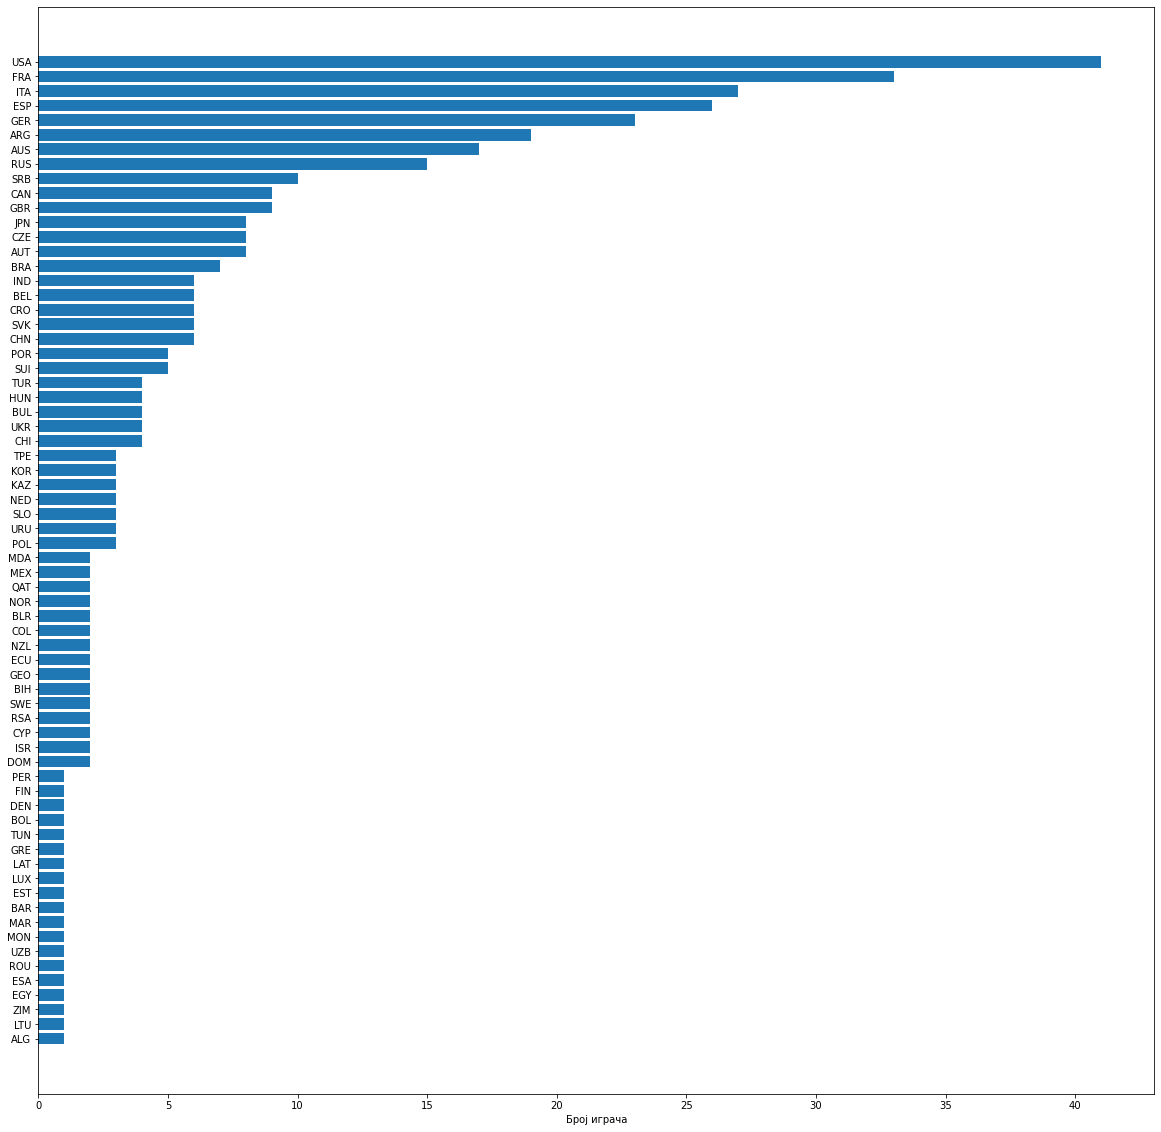

In [29]:
plot_players_per_country_frequency(G)

# 7. Iz kojih zemalja dolaze najuspešniji igrači u smislu osvojenih poena na ATP listi?

In [30]:
def get_first_atp_players(num):
    player_ranks = [(node,attr['player_name'],attr['rank'],attr['country_code']) for (node,attr) in G.nodes(data=True)]

    player_ranks = (list(filter(lambda x: math.isnan(x[2])==False, player_ranks)))
    player_ranks = (sorted(player_ranks, key=lambda element: (element[2]),reverse=False))[:num]
    return player_ranks
    

In [31]:
def plot_best_players_per_country_frequency(countries, xscale = "linear", yscale = "linear"):
    countries_counts = Counter(countries) #prebrojava, 1, 2, ..        
    print(countries_counts)
    lists = sorted(countries_counts.items(),key=lambda item: item[1])
    x, y = zip(*lists)                                                    

    fig = plt.figure(1) 
    fig.set_size_inches(20,20)
    plt.barh(x,y)
    #plt.ylabel('Country')
    plt.xlabel('Број играча')
    plt.show()

Counter({'FRA': 11, 'ESP': 9, 'USA': 8, 'ITA': 6, 'SRB': 5, 'ARG': 5, 'RUS': 5, 'AUS': 5, 'GER': 4, 'JPN': 3, 'CRO': 3, 'CAN': 3, 'SUI': 2, 'GBR': 2, 'CZE': 2, 'KAZ': 2, 'AUT': 1, 'BEL': 1, 'GRE': 1, 'BUL': 1, 'GEO': 1, 'RSA': 1, 'HUN': 1, 'URU': 1, 'POR': 1, 'SLO': 1, 'BIH': 1, 'MDA': 1, 'KOR': 1, 'POL': 1, 'LUX': 1, 'CHI': 1, 'LTU': 1, 'NOR': 1, 'ROU': 1, 'BOL': 1, 'FIN': 1, 'NED': 1, 'IND': 1, 'BRA': 1, 'SVK': 1})


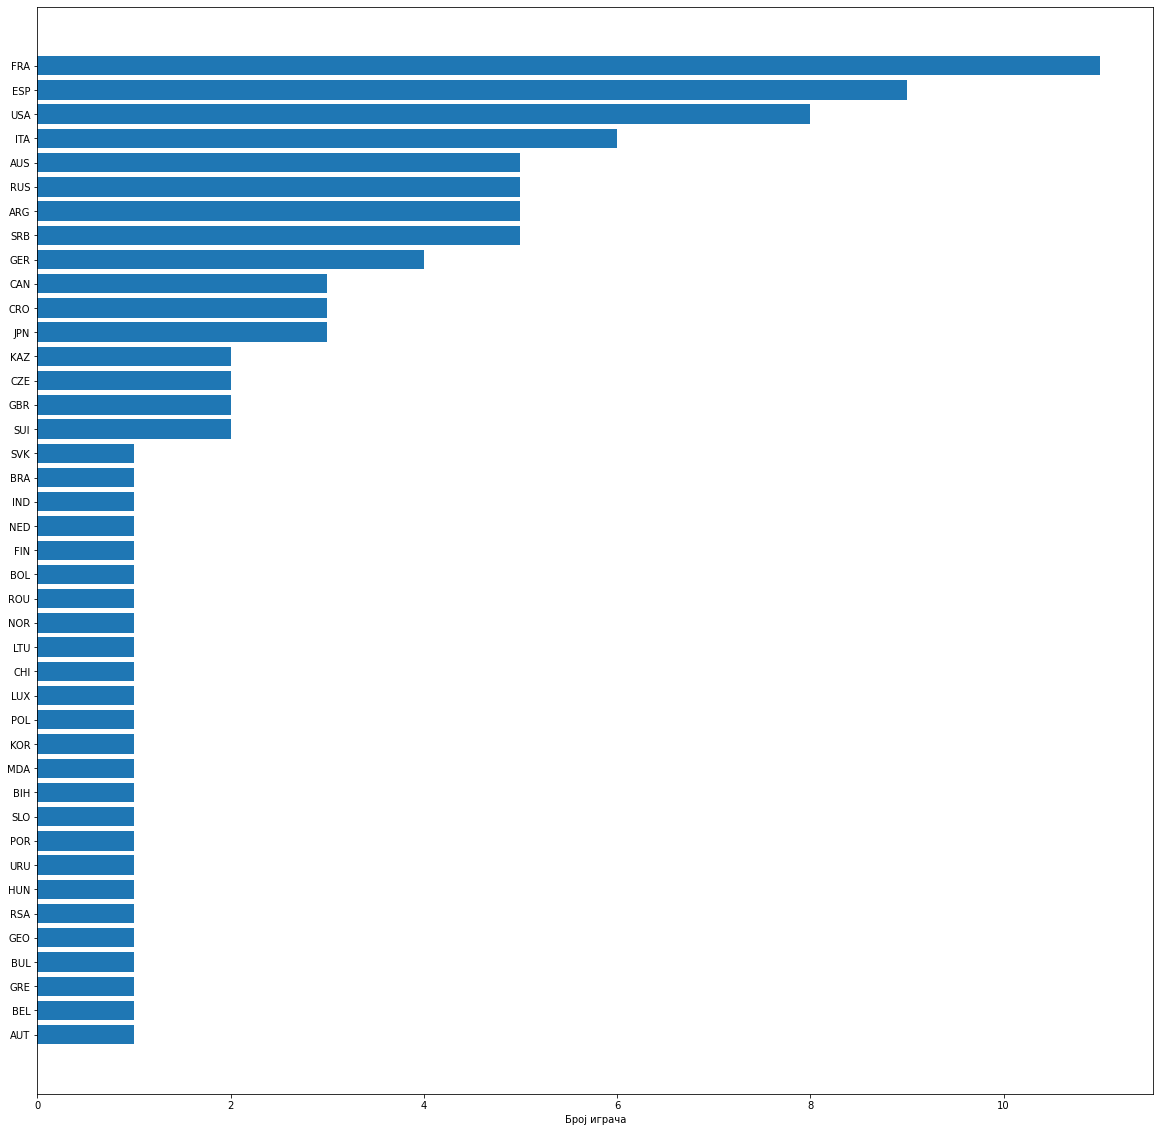

In [32]:
countries = get_first_atp_players(100)
_,_,_,countries = zip(*countries)

#za USA se dosta vidi razlika u 100 i 1000
#ali se pitanje odnosi na najuspesnije
plot_best_players_per_country_frequency(countries)

# 8. Kako su u okviru skupa podataka okarakterisani igrači iz Srbije?

In [33]:
serbian_players = [player for player,country in G.nodes(data='country_code') if country=='SRB']

serbian_players_ranks = [(get_player_info(player)[1],rank) for player,rank in G.nodes(data='rank') if player in serbian_players]
print(f"Po ranku srpski igraci su: {serbian_players_ranks}\n")

serbian_players_matches = [(get_player_info(player)[1],degree) for player,degree in G.degree(weight='weight') if player in serbian_players]
print(f"Po broju meceva srpski igraci su: {serbian_players_matches}\n")

serbian_players_opponents = [(get_player_info(player)[1],degree) for player,degree in G.degree() if player in serbian_players]
print(f"Po broju saigraca srpski igraci su: {serbian_players_opponents}\n")


#Mozda u odnos na druge zemlje?

Po ranku srpski igraci su: [('Dusan Lajovic', 42.92922352941177), ('Viktor Troicki', 163.85206380090497), ('Filip Krajinovic', 47.83839004524887), ('Novak Djokovic', 4.11069185520362), ('Miomir Kecmanovic', 102.99675837104073), ('Laslo Djere', 66.49712398190046), ('Nikola Milojevic', 153.46941176470588), ('Pedja Krstin', 212.8235294117647), ('Janko Tipsarevic', 306.6458333333333), ('Danilo Petrovic', 155.2)]

Po broju meceva srpski igraci su: [('Dusan Lajovic', 122), ('Viktor Troicki', 31), ('Filip Krajinovic', 103), ('Novak Djokovic', 177), ('Miomir Kecmanovic', 73), ('Laslo Djere', 92), ('Nikola Milojevic', 6), ('Pedja Krstin', 1), ('Janko Tipsarevic', 18), ('Danilo Petrovic', 4)]

Po broju saigraca srpski igraci su: [('Dusan Lajovic', 87), ('Viktor Troicki', 30), ('Filip Krajinovic', 71), ('Novak Djokovic', 80), ('Miomir Kecmanovic', 55), ('Laslo Djere', 64), ('Nikola Milojevic', 6), ('Pedja Krstin', 1), ('Janko Tipsarevic', 17), ('Danilo Petrovic', 4)]



# 9. Koje zajednice (komune) se mogu uočiti prilikom analize mreže? Da li postoji neko objašnjenje za detektovane komune?

In [34]:
#Clauset-Newman-Moore pohlepni algoritam
communities = comm.greedy_modularity_communities(G, weight='weight')
communities = [list(community) for community in communities]

# communities_info = {}
# i=0
# for community in communities:
#     i+=1
#     communities_info[i] = get_players_info(community)

communities_info = {}
for i in range(0,len(communities)):
    communities_info[i+1] = get_players_info(communities[i])
    
communities_info

{1: [('106216', 'Bjorn Fratangelo', 137.01602564102564, 'USA'),
  ('103333', 'Ivo Karlovic', 103.16028054298644, 'CRO'),
  ('106401', 'Nick Kyrgios', 33.69977239819005, 'AUS'),
  ('105053', 'Santiago Giraldo', 267.56315987933635, 'COL'),
  ('111815', 'Cameron Norrie', 72.57646968325793, 'GBR'),
  ('127339', 'Borna Gojo', 569.25, 'CRO'),
  ('111202', 'Hyeon Chung', 73.79128959276018, 'KOR'),
  ('125802', 'Ilya Ivashka', 126.08350316742082, 'BLR'),
  ('105649', 'Cedrik Marcel Stebe', 311.53280045248874, 'GER'),
  ('126652', 'Jay Clarke', 200.4334464555053, 'GBR'),
  ('104804', 'Amir Weintraub', nan, 'ISR'),
  ('105311', 'Joao Sousa', 59.67759547511313, 'POR'),
  ('105806', 'Mirza Basic', 148.06052036199094, 'BIH'),
  ('104890', 'Andreas Haider Maurer', 498.2307692307692, 'AUT'),
  ('105992', 'Ryan Harrison', 213.94961945701357, 'USA'),
  ('105063', 'Andrea Arnaboldi', 226.35765460030166, 'ITA'),
  ('111153', 'Christopher Eubanks', 215.75646561085972, 'USA'),
  ('104327', 'Steve Darcis', 

# 10. Sprovesti analizu klasterisanja i asortativnu analizu, pa uporediti grupisanje na osnovu zemlje iz koje igrači dolaze, na osnovu broja mečeva koje igraju i na osnovu rejtinga.

# Analiza klasterisanja

In [35]:
#Lokalni koeficijent klasterizacije
#računa se kao gustina mreže koju čine posmatrani čvor, njegovi susedi i njihove međusobne veze

player_id, clustering_coef = zip(*nx.clustering(G, weight = "weight").items())

not_zero_cc_players = [(get_player_info(player),cc,degree[1])  for player, cc, degree in zip(player_id, clustering_coef, G.degree(weight='weight')) if cc > 0]
not_zero_cc_players = (sorted(not_zero_cc_players, key=lambda element: (element[1]),reverse=True))

max_local_clustering_coef = max(clustering_coef)

average_clustering_coef = nx.average_clustering(G)

print(f"Max lokalni cc: {max_local_clustering_coef}")
print(f"Prosečan cc: {average_clustering_coef}")
print("Lokalni stepeni klasterisanja koji nisu nula:")
#not_zero_cc_players

Max lokalni cc: 0.16508715292071477
Prosečan cc: 0.2920181009831456
Lokalni stepeni klasterisanja koji nisu nula:


## Asortativnost 

In [36]:
# asortativnost na osnovu netežinskog stepena čvora
graph_ass = nx.degree_assortativity_coefficient(G)
print(f"Koeficijent asortativnosti na osnovu netežinskog stepena čvora: {graph_ass}")

# asortativnost na osnovu težinskog stepena čvora
graph_weighted_ass = nx.degree_assortativity_coefficient(G, weight='weight')
print(f"Koeficijent asortativnosti na osnovu težinskog stepena cvora (broja meceva): {graph_weighted_ass}")

#Umereno asortativna mreza? - vezivanje cvorova koji su slicni

# asortativnost na osnovu ranka
graph_rank_ass = nx.attribute_assortativity_coefficient(G, 'rank')
print(f"Koeficijent asortativnosti na osnovu ranka čvora: {graph_rank_ass}")

#U grupe??

Koeficijent asortativnosti na osnovu netežinskog stepena čvora: 0.03928911812802142
Koeficijent asortativnosti na osnovu težinskog stepena cvora (broja meceva): 0.04884585047228479
Koeficijent asortativnosti na osnovu ranka čvora: -0.006009514541495559


In [37]:
max_rank = max([rank for (node,rank) in G.nodes(data='rank')])

def getRankGroup(rank):
    if rank<100:
        return 'group100'
    if rank<250:
        return 'group250'
    if rank<500:
        return 'group500'
    if rank<2000:
        return 'group2000'
    return 'theLastGroup'

def addRankGroupAttributes():
    for player in G.nodes():
        G.nodes[player]['rank_group']=getRankGroup(G.nodes[player]['rank'])

In [38]:
addRankGroupAttributes()

graph_rank_group_ass = nx.attribute_assortativity_coefficient(G, 'rank_group')
print(f"Koeficijent asortativnosti na osnovu kategorije ranka čvora: {graph_rank_group_ass}")

Koeficijent asortativnosti na osnovu kategorije ranka čvora: 0.035709571947467114


In [39]:
# asortativnost na osnovu drzave
graph_rank_ass = nx.attribute_assortativity_coefficient(G, 'country_code')
print(f"Koeficijent asortativnosti na osnovu drzave: {graph_rank_ass}")

Koeficijent asortativnosti na osnovu drzave: 0.008805603198230606


# 11. U kojoj meri teniseri imaju tendenciju da se susreću sa istim teniserima? Da li na to utiče njihovo rangiranje na ATP listi?


In [40]:
def plot_num_of_opponents_per_rank(G, xscale = "linear", yscale = "linear"):
     
    x=[]
    y=[]
    for node,rank in G.nodes(data='rank'):
        x.append(G.degree(weight='weight')[node]/G.degree[node])
        y.append(rank)

    plt.xscale(xscale)                                                                                                                
    #plt.xlim(1, max(x))  
    plt.xlim(1, 2)  

    plt.ylabel('rank')  
    plt.xlabel('broj meceva/broj protivnika') 
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(y))  
                                                                                                                                                                                                    
    plt.scatter(x, y, marker='.')                                                                                                    
    plt.show()

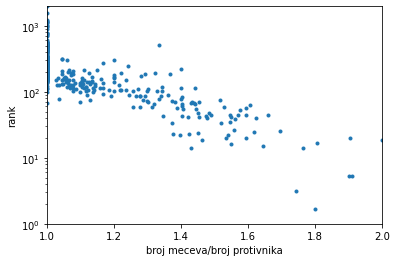

In [41]:
plot_num_of_opponents_per_rank(G,'linear','log')

# 12. Koji teniseri predstavljaju jezgro mreže?


In [42]:
from networkx.algorithms import core

core_graph = core.k_core(G)

print(nx.info(core_graph))

#da li je 78 od 219 jezgro?
core_nodes = [(node,name) for node,name in core_graph.nodes(data='player_name')]

#gustina znatno veca!
nx.density(core_graph)

Name: 
Type: Graph
Number of nodes: 75
Number of edges: 1714
Average degree:  45.7067


0.6176576576576577

# 13. Ko su teniseri koji povezuju različite grupe u okviru mreže?

In [43]:
betweenness_centralities = [(node, centrality) for node, centrality in nx.betweenness_centrality(G).items()]

max_betweenness_centralities = sorted(betweenness_centralities,key=lambda item: item[1], reverse=True)[:10]

high_betweenness_centralities_centrality_players = [(get_player_info(player[0]), player[1]) for player in max_betweenness_centralities]

print(f"Teniseri koji povezuju različite grupe u okviru mreže")
high_betweenness_centralities_centrality_players

Teniseri koji povezuju različite grupe u okviru mreže


[(('105077', 'Albert Ramos', 52.329612217194565, 'ESP'), 0.036740127134148745),
 (('104468', 'Gilles Simon', 47.06257737556562, 'FRA'), 0.03263628848353477),
 (('105138', 'Roberto Bautista Agut', 16.078095022624435, 'ESP'),
  0.029364996777806098),
 (('111815', 'Cameron Norrie', 72.57646968325793, 'GBR'),
  0.028992643039192523),
 (('105932', 'Nikoloz Basilashvili', 34.24743167420815, 'GEO'),
  0.025743892740194285),
 (('105311', 'Joao Sousa', 59.67759547511313, 'POR'), 0.02342557838310319),
 (('126203', 'Taylor Harry Fritz', 45.21454977375566, 'USA'),
  0.02320380897308363),
 (('111575', 'Karen Khachanov', 19.687709502262443, 'RUS'),
  0.023093977453619335),
 (('105807', 'Pablo Carreno Busta', 26.75328597285068, 'ESP'),
  0.02283516207632118),
 (('106043', 'Diego Sebastian Schwartzman', 16.65649004524887, 'ARG'),
  0.022128804698524622)]

# 14. Kolika je gustina svake od modelovanih mreža?

In [44]:
nx.density(G)

0.06430690132489618

# 15. U kojoj meri su mreže povezane i centralizovane?

In [45]:
_,degrees = zip(*G.degree())

N=len(degrees)
max_degree = max(degrees)

#sum(max(x)-x)/(length(x)-1)
centralization = float((N*max_degree - sum(degrees)))/(N-1)**2

centralization

0.19068073829805512

In [46]:
def plot_players_per_centralities_frequency(G, xscale = "linear", yscale = "linear"):

    degree_centralities = [centrality for node, centrality in nx.degree_centrality(G).items()]
    centralities_counts = Counter(degree_centralities) #prebrojava, 1, 2, ..        
    print(centralities_counts)
    #lists = sorted(centralities_counts.items(),key=lambda item: item[1])
    x,frequency = zip(*centralities_counts.items())                                                      

    fig = plt.figure(1) 
    plt.xlabel('degree centrality')  
    plt.xscale(xscale)                                                                                                                
    plt.xlim(0, max(x))  

    plt.ylabel('frequency')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(frequency))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(x, frequency, marker='.')  
    plt.show()   

Counter({0.002570694087403599: 64, 0.005141388174807198: 43, 0.007712082262210797: 26, 0.012853470437017993: 16, 0.015424164524421594: 16, 0.02313624678663239: 9, 0.010282776349614395: 9, 0.033419023136246784: 8, 0.01799485861182519: 8, 0.038560411311053984: 7, 0.04370179948586118: 6, 0.02056555269922879: 6, 0.07455012853470437: 5, 0.1979434447300771: 5, 0.056555269922879174: 5, 0.2082262210796915: 5, 0.15681233933161953: 5, 0.07197943444730076: 4, 0.12596401028277635: 4, 0.03598971722365038: 4, 0.08997429305912595: 4, 0.04884318766066838: 4, 0.2210796915167095: 4, 0.09768637532133675: 4, 0.04627249357326478: 4, 0.2262210796915167: 3, 0.11053984575835475: 3, 0.05398457583547558: 3, 0.051413881748071974: 3, 0.10539845758354754: 3, 0.15167095115681234: 3, 0.2056555269922879: 3, 0.12339331619537275: 3, 0.06683804627249357: 3, 0.23907455012853468: 3, 0.19023136246786632: 3, 0.2287917737789203: 3, 0.16966580976863752: 3, 0.025706940874035987: 3, 0.1722365038560411: 3, 0.13367609254498714: 3

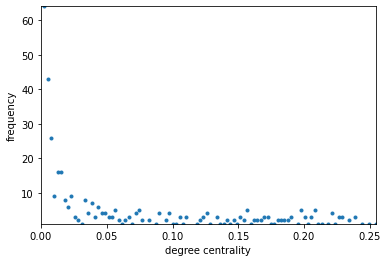

In [47]:
#ako ima nekoliko koji se izdvajaju sa velikom centralnoscu - centralizovan
#nas nije
plot_players_per_centralities_frequency(G)

In [48]:
# returns number of nodes to be removed 
# so that Graph becomes disconnected 
print(nx.node_connectivity(G)) 
  
# returns number of edges to be removed 
# so that Graph becomes disconnected 
print(nx.edge_connectivity(G))

#treba mnogo vremena!!!
#nx.average_node_connectivity(G)

1
1


# 16. Koje su prosečne distance, a koliki dijametar u okviru modelovanih mreža?

In [49]:
#ovoga vise nema kad smo izbacili Davis Cup!
# for g in [G.subgraph(c) for c in nx.connected_components(G)]: 
#     if len(g.nodes())<=4:
#         small_components=get_players_info(g.nodes())
#     if len(g.nodes())==19:
#         one_bigger_component=getPlayersInfo(g.nodes())
        
if nx.is_connected(G):
    print(f'Prosecna distanca: {(nx.average_shortest_path_length(G))}')
    print(f'Dijametar: {nx.diameter(G)}')

Prosecna distanca: 2.5101179882670883
Dijametar: 6


# 17. Kakva je distribucija čvorova po stepenu i da li prati neku zakonomernost? Kako je stepen čvora korelisan sa rejtingom tenisera?

Counter({1: 64, 2: 43, 3: 26, 5: 16, 6: 16, 9: 9, 4: 9, 13: 8, 7: 8, 15: 7, 17: 6, 8: 6, 29: 5, 77: 5, 22: 5, 81: 5, 61: 5, 28: 4, 49: 4, 14: 4, 35: 4, 19: 4, 86: 4, 38: 4, 18: 4, 88: 3, 43: 3, 21: 3, 20: 3, 41: 3, 59: 3, 80: 3, 48: 3, 26: 3, 93: 3, 74: 3, 89: 3, 66: 3, 10: 3, 67: 3, 52: 3, 78: 3, 16: 3, 91: 2, 60: 2, 71: 2, 73: 2, 23: 2, 57: 2, 72: 2, 30: 2, 64: 2, 63: 2, 70: 2, 55: 2, 47: 2, 32: 2, 25: 2, 37: 2, 65: 2, 11: 2, 82: 1, 40: 1, 87: 1, 56: 1, 53: 1, 39: 1, 62: 1, 34: 1, 50: 1, 69: 1, 54: 1, 76: 1, 68: 1, 83: 1, 85: 1, 58: 1, 27: 1, 79: 1, 12: 1, 97: 1, 42: 1, 46: 1, 95: 1, 99: 1, 24: 1})


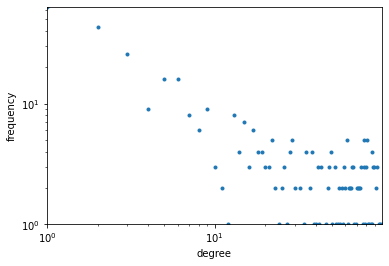

In [50]:
plot_deg_frequency(G, weighted=False)

In [51]:
def plot_deg_distribution(G, weighted=False, xscale = "log", yscale = "log"):

    if weighted:
        degrees = G.degree(weight="weight")
    else:
        degrees = G.degree()
    _, deg_list = zip(*degrees)    #unzip
    deg_counts = Counter(deg_list) #prebrojava, 1, 2, ..        
    print(deg_counts)
    degree, frequency = zip(*deg_counts.items())                                                      

    fig = plt.figure(1)
    plt.ylabel('degree')
    plt.ylabel('Broj cvorova')
    ax = fig.add_axes([0,0,1,1])
    ax.bar(degree,frequency)
    plt.show()

Counter({1: 64, 2: 43, 3: 26, 5: 16, 6: 16, 9: 9, 4: 9, 13: 8, 7: 8, 15: 7, 17: 6, 8: 6, 29: 5, 77: 5, 22: 5, 81: 5, 61: 5, 28: 4, 49: 4, 14: 4, 35: 4, 19: 4, 86: 4, 38: 4, 18: 4, 88: 3, 43: 3, 21: 3, 20: 3, 41: 3, 59: 3, 80: 3, 48: 3, 26: 3, 93: 3, 74: 3, 89: 3, 66: 3, 10: 3, 67: 3, 52: 3, 78: 3, 16: 3, 91: 2, 60: 2, 71: 2, 73: 2, 23: 2, 57: 2, 72: 2, 30: 2, 64: 2, 63: 2, 70: 2, 55: 2, 47: 2, 32: 2, 25: 2, 37: 2, 65: 2, 11: 2, 82: 1, 40: 1, 87: 1, 56: 1, 53: 1, 39: 1, 62: 1, 34: 1, 50: 1, 69: 1, 54: 1, 76: 1, 68: 1, 83: 1, 85: 1, 58: 1, 27: 1, 79: 1, 12: 1, 97: 1, 42: 1, 46: 1, 95: 1, 99: 1, 24: 1})


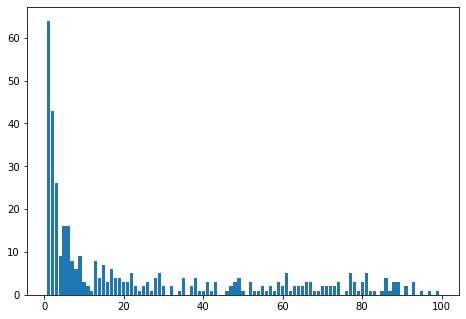

In [52]:
plot_deg_distribution(G)
#plot_deg_distribution(G, weighted=True)

In [53]:
def plot_rank_degree(G, weight=True, xscale = "log", yscale = "log"):

    if (weight):
        rank_degree = [(rank,G.degree(weight='weight')[node]) for node,rank in G.nodes(data='rank')]
    else:
        rank_degree = [(rank,G.degree()[node]) for node,rank in G.nodes(data='rank')]
    rank, degree = zip(*rank_degree)                                                      

    plt.figure(1)   

    # prep axes   
    plt.xlabel('rank')                                                                                                             
    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(rank))  

    plt.ylabel('degree')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(degree))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(rank, degree, marker='.')                                                                                                    
    plt.show()

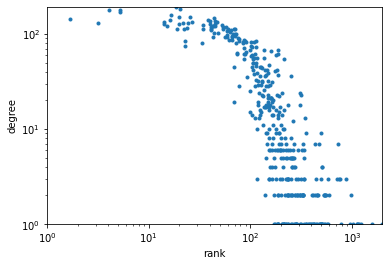

In [54]:
plot_rank_degree(G)

# 18. Da li u mreži postoje habovi i koji su? 

In [55]:
hubs,authorities = nx.hits(G)

high_hubs_players = [(get_player_info(node), h) for node,h in sorted(hubs.items(), key=lambda element: (element[1]),reverse=True)][:10]

high_hubs_players

#moze i eigen_vector

[(('126774', 'Stefanos Tsitsipas', 18.37666153846154, 'GRE'),
  0.01798627924621419),
 (('104925', 'Novak Djokovic', 4.11069185520362, 'SRB'), 0.017222334238052195),
 (('106421', 'Daniil Medvedev', 20.165200904977375, 'RUS'),
  0.016328986046245483),
 (('106233', 'Dominic Thiem', 5.275989140271493, 'AUT'), 0.016231034503788277),
 (('100644', 'Alexander Zverev', 5.227398190045249, 'GER'),
  0.0158386640293685),
 (('104745', 'Rafael Nadal', 1.6879619909502261, 'ESP'), 0.014212397831846304),
 (('106043', 'Diego Sebastian Schwartzman', 16.65649004524887, 'ARG'),
  0.013104752777131183),
 (('133430', 'Denis Shapovalov', 25.242005429864253, 'CAN'),
  0.012875783452313636),
 (('103819', 'Roger Federer', 3.171956108597285, 'SUI'), 0.012551526701270072),
 (('111575', 'Karen Khachanov', 19.687709502262443, 'RUS'),
  0.012076127995941951)]

# 19. Da li mreža tenisera iskazuje osobine malog sveta?
A small world network is characterized by a small average shortest path length, and a large clustering coefficient.

Small-worldness is commonly measured with the coefficient sigma or omega.

Both coefficients compare the average clustering coefficient and shortest path length of a given graph against the same quantities for an equivalent random or lattice graph.

In [56]:
# #sigma>1
# sigma = nx.sigma(G)

# #~0
# omega = nx.omega(G)

# 20. Kakve su karakteristike ego mreža članova Velike trojke? U kojoj meri se te karakteristike razlikuju?

In [57]:
def get_average_ranks(G):
    ranks = [rank for node,rank in G.nodes(data='rank')]
    return sum(ranks)/len(ranks)

In [58]:
novak_id = get_player_by_name("Novak Djokovic")
rafa_id = get_player_by_name("Rafael Nadal")
federer_id = get_player_by_name("Roger Federer")

novak_ego_graph = nx.ego_graph(G,novak_id)
print(f"Novakova ego mreza : {nx.info(novak_ego_graph)}")
print(f"Prosecan tezinski stepen : {get_average_weighted_degree(novak_ego_graph)}")
print(f"Gustina mreze : {nx.density(novak_ego_graph)}")
print(f"Prosecan rank tenisera mreze : {get_average_ranks(novak_ego_graph)}")
novak_degree_centrality = [centrality for node, centrality in nx.degree_centrality(novak_ego_graph).items() if node==novak_id]
novak_eigenvector_centrality = [centrality for node, centrality in nx.eigenvector_centrality(novak_ego_graph).items() if node==novak_id]
print(f"Degree centrality : {novak_degree_centrality}")
print(f"Eigenvector centrality : {novak_eigenvector_centrality}")
print("\n")

rafa_ego_graph = nx.ego_graph(G,rafa_id)
print(f"Nadalova ego mreza : {nx.info(rafa_ego_graph)}")
print(f"Prosecan tezinski stepen : {get_average_weighted_degree(rafa_ego_graph)}")
print(f"Gustina mreze : {nx.density(rafa_ego_graph)}")
print(f"Prosecan rank tenisera mreze : {get_average_ranks(rafa_ego_graph)}")
rafa_degree_centrality = [centrality for node, centrality in nx.degree_centrality(rafa_ego_graph).items() if node==rafa_id]
rafa_eigenvector_centrality = [centrality for node, centrality in nx.eigenvector_centrality(rafa_ego_graph).items() if node==rafa_id]
print(f"Degree centrality : {rafa_degree_centrality}")
print(f"Eigenvector centrality : {rafa_eigenvector_centrality}")
print("\n")

federer_ego_graph = nx.ego_graph(G,federer_id)
print(f"Federerova ego mreza : {nx.info(federer_ego_graph)}")
print(f"Prosecan tezinski stepen : {get_average_weighted_degree(federer_ego_graph)}")
print(f"Gustina mreze : {nx.density(federer_ego_graph)}")
print(f"Prosecan rank tenisera mreze : {get_average_ranks(federer_ego_graph)}")
federer_degree_centrality = [centrality for node, centrality in nx.degree_centrality(federer_ego_graph).items() if node==federer_id]
federer_eigenvector_centrality = [centrality for node, centrality in nx.eigenvector_centrality(federer_ego_graph).items() if node==federer_id]
print(f"Degree centrality : {federer_degree_centrality}")
print(f"Eigenvector centrality : {federer_eigenvector_centrality}")

Novakova ego mreza : Name: 
Type: Graph
Number of nodes: 81
Number of edges: 1294
Average degree:  31.9506
Prosecan tezinski stepen : 53.82716049382716
Gustina mreze : 0.3993827160493827
Prosecan rank tenisera mreze : 73.14590409288124
Degree centrality : [1.0]
Eigenvector centrality : [0.21077147584312816]


Nadalova ego mreza : Name: 
Type: Graph
Number of nodes: 81
Number of edges: 1356
Average degree:  33.4815
Prosecan tezinski stepen : 54.19753086419753
Gustina mreze : 0.4185185185185185
Prosecan rank tenisera mreze : 83.17761398804538
Degree centrality : [1.0]
Eigenvector centrality : [0.20811192815602284]


Federerova ego mreza : Name: 
Type: Graph
Number of nodes: 75
Number of edges: 1366
Average degree:  36.4267
Prosecan tezinski stepen : 61.12
Gustina mreze : 0.4922522522522523
Prosecan rank tenisera mreze : 64.01125075917545
Degree centrality : [1.0]
Eigenvector centrality : [0.1991820839259091]


In [59]:
novak_nodes = set(novak_ego_graph.nodes())
rafa_nodes = set(rafa_ego_graph.nodes())
federer_nodes = set(federer_ego_graph.nodes())

novak_rafa_node = novak_nodes.intersection(rafa_nodes)
novak_federer_node = novak_nodes.intersection(federer_nodes)
rafa_federer_node = rafa_nodes.intersection(federer_nodes)

print(f"Novak i Rafa: {len(novak_rafa_node)}")
print(f" {get_players_info(novak_rafa_node)}")
print("\n")
print(f"Novak i Federer: {len(novak_federer_node)}")
print(f" {get_players_info(novak_federer_node)}")
print("\n")
print(f"Federer i Rafa: {len(rafa_federer_node)}")
print(f" {get_players_info(rafa_federer_node)}")

Novak i Rafa: 41
 [('105223', 'Juan Martin Del Potro', 22.905165912518854, 'ARG'), ('105936', 'Filip Krajinovic', 47.83839004524887, 'SRB'), ('105023', 'Sam Querrey', 43.17985610859729, 'USA'), ('106148', 'Roberto Carballes Baena', 87.71690678733032, 'ESP'), ('111575', 'Karen Khachanov', 19.687709502262443, 'RUS'), ('103819', 'Roger Federer', 3.171956108597285, 'SUI'), ('104527', 'Stanislas Wawrinka', 41.23290226244344, 'SUI'), ('105777', 'Grigor Dimitrov', 22.150169230769233, 'BUL'), ('104925', 'Novak Djokovic', 4.11069185520362, 'SRB'), ('126203', 'Taylor Harry Fritz', 45.21454977375566, 'USA'), ('104871', 'Jeremy Chardy', 59.5815113122172, 'FRA'), ('111202', 'Hyeon Chung', 73.79128959276018, 'KOR'), ('100644', 'Alexander Zverev', 5.227398190045249, 'GER'), ('105227', 'Marin Cilic', 20.065719909502263, 'CRO'), ('104792', 'Gael Monfils', 21.95124343891403, 'FRA'), ('106043', 'Diego Sebastian Schwartzman', 16.65649004524887, 'ARG'), ('105173', 'Adrian Mannarino', 40.37171266968326, 'FR

# 21. Kakva je pozicija ego čvora u svakoj od ego mreža? Kako su oni strukturno ugrađeni u mrežu?

In [60]:
novak_edges = [edge for edge in novak_ego_graph.edges(nbunch=novak_id)]
edges = novak_ego_graph.edges()

print(f"Procenat Novakovih veza = {len(novak_edges)*100/len(edges)}")

rafa_edges = [edge for edge in rafa_ego_graph.edges(nbunch=rafa_id)]
edges = rafa_ego_graph.edges()

print(f"Procenat Nadalovih veza = {len(rafa_edges)*100/len(edges)}")

federer_edges = [edge for edge in federer_ego_graph.edges(nbunch=federer_id)]
edges = novak_ego_graph.edges()

print(f"Procenat Federerovih veza = {len(federer_edges)*100/len(edges)}")

Procenat Novakovih veza = 6.182380216383308
Procenat Nadalovih veza = 5.899705014749262
Procenat Federerovih veza = 5.7187017001545595


# 22. Kako su posmatrane ego mreže ugrađene u mrežu tenisera?

In [61]:
novak_ego_edges = [edge for edge in novak_ego_graph.edges()]
edges = [edge for edge in G.edges()]

print(f"Procenat Novakovih veza u ego i obicnoj mrezi = {len(novak_ego_edges)*100/len(edges)}")
print(f"Procenat Novakovih suparnika u obicnoj mrezi = {len(novak_nodes)*100/len(G.nodes())}")

Procenat Novakovih veza u ego i obicnoj mrezi = 26.527265272652727
Procenat Novakovih suparnika u obicnoj mrezi = 20.76923076923077


In [62]:
rafa_ego_edges = [edge for edge in rafa_ego_graph.edges()]
edges = [edge for edge in G.edges()]

print(f"Procenat Nadalovih veza u ego i obicnoj mrezi = {len(rafa_ego_edges)*100/len(edges)}")
print(f"Procenat Nadalovih suparnika u obicnoj mrezi = {len(rafa_nodes)*100/len(G.nodes())}")

Procenat Nadalovih veza u ego i obicnoj mrezi = 27.798277982779826
Procenat Nadalovih suparnika u obicnoj mrezi = 20.76923076923077


In [63]:
federer_ego_edges = [edge for edge in federer_ego_graph.edges()]
edges = [edge for edge in G.edges()]

print(f"Procenat Federerovih veza u ego i obicnoj mrezi = {len(federer_ego_edges)*100/len(edges)}")
print(f"Procenat Federerovih suparnika u obicnoj mrezi = {len(federer_nodes)*100/len(G.nodes())}")

Procenat Federerovih veza u ego i obicnoj mrezi = 28.00328003280033
Procenat Federerovih suparnika u obicnoj mrezi = 19.23076923076923


In [64]:
ugo_id = get_player_by_name('Ugo Humbert')
ugo_id in novak_nodes

True

# 23. Analizirati mrežu dobijenu unifikacijom ego mreža članova Velike trojke.
## Koji procenat čvorova mreže svih tenisera učestvuje u njoj?
## Sprovesti klasterisanje ovako dobijene mreže na tri klastera i na osnovu dobijenih rezultata dati interpretaciju kriterijuma pripadnosti klasterima.


In [65]:
all_edges = set(novak_ego_edges).union(set(rafa_ego_edges)).union(set(federer_ego_edges))

u = G.edge_subgraph(all_edges)
print(f"Unificirana mreza : {nx.info(u)}")
print(f"Prosecan tezinski stepen : {get_average_weighted_degree(u)}")
print(f"Gustina mreze : {nx.density(u)}")
print(f"Prosecan rank tenisera mreze : {get_average_ranks(u)}")

Unificirana mreza : Name: 
Type: Graph
Number of nodes: 135
Number of edges: 2508
Average degree:  37.1556
Prosecan tezinski stepen : 57.614814814814814
Gustina mreze : 0.27728026533996686
Prosecan rank tenisera mreze : 93.70733423942798


In [66]:
print(f"Procenat cvorova u unificirano mrezi = {len(u.nodes())*100/len(G.nodes())}")

Procenat cvorova u unificirano mrezi = 34.61538461538461


In [67]:
data = u.nodes()
edge_mat = nx.to_numpy_matrix(u,nodelist=data,weight='weight')

kmeans = cluster.KMeans(n_clusters=3, n_init=200)

kmeans = kmeans.fit(edge_mat)

#initialize dict
clusters = {}
for index in range(0,3): 
    nodes = []    
    clusters[index] = nodes
    
for cluster_info in zip(data,kmeans.labels_):
    clusters[cluster_info[1]].append(cluster_info[0])
clusters

{0: ['106210',
  '144895',
  '105575',
  '106216',
  '123755',
  '111202',
  '106423',
  '106198',
  '105902',
  '126652',
  '104607',
  '200175',
  '105806',
  '104547',
  '200615',
  '104655',
  '106426',
  '104665',
  '104297',
  '200624',
  '106045',
  '126952',
  '144750',
  '105577',
  '104424',
  '105238',
  '106071',
  '106228',
  '103607',
  '206173',
  '105882',
  '105166',
  '136440',
  '106214',
  '111576',
  '104198',
  '111456',
  '105147',
  '106099',
  '105074',
  '105216',
  '144707',
  '106283',
  '105967',
  '105657',
  '103970',
  '105870',
  '106121',
  '104898',
  '104291',
  '106078',
  '104534',
  '105041',
  '144719',
  '111442',
  '111577',
  '104999',
  '105051',
  '106148',
  '104797',
  '105385',
  '120424',
  '200005',
  '109739',
  '103852',
  '105373',
  '104620'],
 1: ['103819',
  '106043',
  '133430',
  '104925',
  '100644',
  '106233',
  '126774',
  '126094',
  '104745',
  '106421',
  '111575'],
 2: ['104527',
  '105062',
  '106401',
  '105554',
  '10

In [68]:
N = len(u.nodes())

num_of_ego_graphs = {}
for node in u.nodes():
    n = 1 if node in novak_ego_graph else 0
    r = 1 if node in rafa_ego_graph else 0
    f = 1 if node in federer_ego_graph else 0
    num_of_ego_graphs[node] = n+r+f

edge_matrix =  np.array([[0 for i in range(2)]] * N )
node_index = 0
for node in u.nodes():
    for neighbor in u.neighbors(node):
        neighbor_index = list(u.nodes()).index(neighbor)
        edge_matrix[node_index,1] = num_of_ego_graphs[node]
    node_index+=1
        
edge_matrix

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 3],
       [0, 1],
       [0, 3],
       [0, 1],
       [0, 2],
       [0, 2],
       [0, 1],
       [0, 3],
       [0, 2],
       [0, 2],
       [0, 3],
       [0, 3],
       [0, 1],
       [0, 2],
       [0, 2],
       [0, 1],
       [0, 3],
       [0, 3],
       [0, 2],
       [0, 3],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 3],
       [0, 1],
       [0, 3],
       [0, 1],
       [0, 3],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 3],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 1],
       [0, 1],
       [0, 3],
       [0, 3],
       [0, 3],
       [0, 3],
       [0, 1],
       [0, 3],
       [0, 1],
       [0, 2],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 2],
       [0, 1],
       [0,

In [69]:
kmeans = cluster.KMeans(n_clusters=3, n_init=200)

kmeans = kmeans.fit(edge_matrix)

#initialize dict
big_three_clusters = {}
for index in range(0,3): 
    nodes = []    
    big_three_clusters[index] = nodes
    
for cluster_info in zip(data,kmeans.labels_):
    big_three_clusters[cluster_info[1]].append(cluster_info[0])
big_three_clusters

{0: ['106401',
  '105554',
  '104731',
  '105550',
  '106043',
  '106423',
  '105077',
  '104607',
  '105815',
  '200282',
  '106045',
  '106432',
  '104545',
  '104926',
  '128034',
  '104919',
  '105683',
  '106298',
  '105023',
  '126094',
  '106378',
  '105379',
  '105916',
  '105807',
  '134770',
  '105932',
  '104999',
  '105051',
  '106148',
  '111575',
  '105373',
  '105449',
  '132283',
  '104259'],
 1: ['106210',
  '144895',
  '105575',
  '106216',
  '105062',
  '123755',
  '105430',
  '106198',
  '105902',
  '126652',
  '200175',
  '105806',
  '104547',
  '200615',
  '104655',
  '106426',
  '104665',
  '104297',
  '200624',
  '126952',
  '144750',
  '105577',
  '104424',
  '105238',
  '106071',
  '103607',
  '206173',
  '105882',
  '105166',
  '136440',
  '106214',
  '111576',
  '104198',
  '200000',
  '104468',
  '106065',
  '111456',
  '105147',
  '106099',
  '105074',
  '105216',
  '144707',
  '106283',
  '105967',
  '105657',
  '103970',
  '105870',
  '106121',
  '126207

In [70]:
def get_players_cluster(id):
    for cluster_index in range(0,3):
        if id in clusters[cluster_index]:
            return cluster_index

In [71]:
get_players_cluster(novak_id)

1

In [72]:
get_players_cluster(rafa_id)

1

In [73]:
get_players_cluster(federer_id)

1

In [74]:
# asyn_fluid_clusters = {}
# for (community_info) in zip(range(0,3),comm.asyn_fluidc(u,3)): 
#     asyn_fluid_clusters[community_info[0]] = list(community_info[1])
    
# # for c in comm.asyn_fluidc(G,3):
# #     asyn_fluid_communities[index] = c
# asyn_fluid_clusters

# 24. Kakva je distribucija broja tenisera u odnosu na broj mečeva koji su odigrali?

Counter({1: 64, 2: 43, 3: 25, 6: 17, 5: 13, 7: 10, 4: 10, 9: 7, 14: 6, 18: 6, 17: 6, 21: 5, 10: 5, 8: 5, 45: 4, 13: 4, 23: 4, 28: 4, 19: 4, 16: 4, 42: 4, 32: 3, 67: 3, 24: 3, 56: 3, 36: 3, 84: 3, 61: 3, 114: 3, 112: 3, 29: 3, 11: 3, 15: 3, 49: 2, 121: 2, 55: 2, 60: 2, 100: 2, 127: 2, 92: 2, 62: 2, 31: 2, 37: 2, 177: 2, 73: 2, 74: 2, 87: 2, 118: 2, 82: 2, 123: 2, 39: 2, 93: 2, 22: 2, 81: 2, 113: 2, 83: 2, 135: 1, 91: 1, 136: 1, 110: 1, 63: 1, 120: 1, 122: 1, 146: 1, 85: 1, 80: 1, 116: 1, 128: 1, 117: 1, 111: 1, 102: 1, 71: 1, 144: 1, 151: 1, 134: 1, 130: 1, 44: 1, 129: 1, 38: 1, 107: 1, 103: 1, 88: 1, 133: 1, 20: 1, 50: 1, 54: 1, 96: 1, 66: 1, 159: 1, 59: 1, 41: 1, 106: 1, 25: 1, 99: 1, 86: 1, 141: 1, 138: 1, 65: 1, 170: 1, 46: 1, 126: 1, 12: 1, 194: 1, 139: 1, 94: 1, 58: 1, 181: 1, 131: 1, 152: 1, 26: 1, 98: 1, 47: 1, 33: 1, 35: 1})


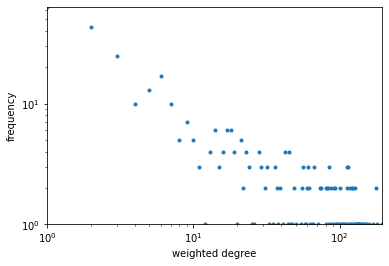

In [75]:
plot_deg_frequency(G, weighted = True)

# Cuvanje grafa

In [76]:
nx.write_gexf(G,output_gz_path)

# Vizuelizacija

In [77]:
def get_gephi_rank_group(rank):
    if rank<10:
        return 'group10'
    if rank<20:
        return 'group20'
    if rank<50:
        return 'group50'
    if rank<100:
        return 'group100'
    if rank<250:
        return 'group250'
    if rank<500:
        return 'group500'
    if rank<2000:
        return 'group2000'
    return 'group2000'

def add_gephi_rank_group_attribute(G):
    for player in G.nodes:
        G.nodes[player]['rank_group']=get_gephi_rank_group(G.nodes[player]['rank'])
        
def reverse_rank(G):
    for player in G.nodes:
        rank = G.nodes[player]['rank']
        G.nodes[player]['rank']=-rank if not np.isnan(rank) else -float(2000)

def set_ego_node_attribute(G,ego_nodes,ego_type):  
    for player in G.nodes:
        G.nodes[player]['node_type']=ego_type if player in ego_nodes else 'not_ego_node'
        
def set_ego_edge_attribute(G,ego_edges,ego_type):         
    for (source,target) in G.edges:
        G.edges[source,target]['edge_type']=ego_type if (((source,target) in ego_edges) | ((target,source) in ego_edges)) else 'not_ego_edge'          
        
def set_ego_attribute(G,ego_nodes,ego_edges,ego_type):  
    set_ego_node_attribute(G,ego_nodes,ego_type)
    set_ego_edge_attribute(G,ego_edges,ego_type)

def set_community_attribute(G):
    for key, values in communities_info.items():
        for value in values:
            G.nodes[value[0]]['community'] = key

def set_cluster_attribute(G):
    for key, values in clusters.items():
        for value in values:
            G.nodes[value]['cluster'] = key
    # hocu da mi se u gephi-ju prikazuje label samo za ovu trojicu pa cu to ovako da uradim
    for player in G.nodes():
        G.nodes[player]['help_label'] = G.nodes[player]['player_name'] if G.nodes[player]['player_name'] in ['Novak Djokovic', 'Rafael Nadal', 'Roger Federer'] else ''
        
def set_big_three_clusters_attribute(G):
    for key, values in big_three_clusters.items():
        for value in values:
            G.nodes[value]['big_three_clusters'] = key
    # hocu da mi se u gephi-ju prikazuje label samo za ovu trojicu pa cu to ovako da uradim
    for player in G.nodes():
        G.nodes[player]['help_label'] = G.nodes[player]['player_name'] if G.nodes[player]['player_name'] in ['Novak Djokovic', 'Rafael Nadal', 'Roger Federer'] else ''
        

In [78]:
def relable(G):
    values = [name for node,name in G.nodes(data='player_name')]
    mapping  = dict(zip(G, values))

    return  nx.relabel_nodes(G, mapping)   

def arrange_graph(G):
    H = copy.deepcopy(G)

    add_gephi_rank_group_attribute(H)
    
    reverse_rank(H)    
    return relable(H)

def arrange_ego_in_graph(G,nodes,edges,node_type):
    H = copy.deepcopy(G)
    
    set_ego_attribute(H,nodes,edges,node_type)
    reverse_rank(H) 
    return relable(H)

def arrange_ego_graph(G,edges,node_type):
    H = copy.deepcopy(G)
    
    set_ego_edge_attribute(H,edges,node_type)
    reverse_rank(H) 
    return relable(H)

def arrange_communities(G):
    H = copy.deepcopy(G)
    
    set_community_attribute(H)
    add_gephi_rank_group_attribute(H)
    reverse_rank(H)
    return relable(H)

def arrange_clusters(G):
    H = copy.deepcopy(G)
    
    set_cluster_attribute(H)
    add_gephi_rank_group_attribute(H)
    reverse_rank(H)
    return relable(H)

def arrange_big_three_clusters(G):
    H = copy.deepcopy(G)
    
    set_big_three_clusters_attribute(H)
    add_gephi_rank_group_attribute(H)
    reverse_rank(H)
    return relable(H)

In [79]:
nx.write_gml(arrange_graph(G), output_gml_path)

nx.write_gml(arrange_ego_in_graph(G,novak_nodes,novak_ego_edges,'novak'), "novak_ego_in_aggregated.gml")
nx.write_gml(arrange_ego_in_graph(G,rafa_nodes,rafa_ego_edges,'rafa'), "rafa_ego_in_aggregated.gml")
nx.write_gml(arrange_ego_in_graph(G,federer_nodes,federer_ego_edges,'federer'), "federer_ego_in_aggregated.gml")

nx.write_gml(arrange_ego_graph(novak_ego_graph,novak_edges,'novak'), "novak_ego_graph_aggregated.gml")
nx.write_gml(arrange_ego_graph(rafa_ego_graph,rafa_edges,'rafa'), "rafa_ego_graph_aggregated.gml")
nx.write_gml(arrange_ego_graph(federer_ego_graph,federer_edges,'federer'), "federer_ego_graph_aggregated.gml")

nx.write_gml(arrange_communities(G), "communities_aggregated.gml")
nx.write_gml(arrange_clusters(u), "clusters_unified_graph_aggregated.gml")


#asyn_fluid_clusters
#nx.write_gml(arrange_asyn_fluid_clusters(u), "asyn_fluid_clusters_unified_graph_aggregated.gml")

nx.write_gml(arrange_big_three_clusters(u), "arrange_big_three_clusters_unified_graph_aggregated.gml")